<a href="https://colab.research.google.com/github/Harris512/AI_Cyberinfrastructure_work/blob/main/Copy_of_camp_logreg_microbit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a target="_blank" href="https://colab.research.google.com/github/cyneuro/ML_camp/blob/main/camp_logreg_microbit.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Logistic regression with micro:bit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 1. Read and preprocess the data

- Read the recorded dataset.
- Compute velocity and position from acceleration.

In [ ]:
# Convert milligravities to m/s2
MG_TO_MS2 = 0.00980665

def process_data(data):
    # Clean the columns
    orig_columns = ["time (seconds)", "x", "y", "z"]
    new_columns = ["t", "ax", "ay", "az"]
    data = data[orig_columns]
    data.columns = new_columns

    # Clean NaNs
    data = data.dropna()

    # Convert to m/s2
    for acc in ['ax', 'ay', 'az']:
        data[acc] = data[acc] * MG_TO_MS2

    # Replace outliers with the median
    for acc in ['ax', 'ay', 'az']:
        acc_raw = data[acc].copy()
        acc_raw[np.abs(acc_raw / np.median(acc_raw)) > 1.5] = np.median(acc_raw)
        data[acc] = acc_raw

    # Compute velocity
    data['vx'] = cumulative_trapezoid(data['ax'], data['t'], initial = 0)
    data['vy'] = cumulative_trapezoid(data['ay'], data['t'], initial = 0)
    data['vz'] = cumulative_trapezoid(data['az'], data['t'], initial = 0)

    # Compute position
    data['x'] = cumulative_trapezoid(data['vx'], data['t'], initial = 0)
    data['y'] = cumulative_trapezoid(data['vy'], data['t'], initial = 0)
    data['z'] = cumulative_trapezoid(data['vz'], data['t'], initial = 0)

    return data

In [ ]:
data = pd.read_csv("shake_data.csv")
data = process_data(data)
data.head()

,t,ax,ay,az,vx,vy,vz,x,y,z
0,13.75,-0.117680,-0.431493,-10.198916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,13.85,-0.078453,-0.117680,-10.081236,-0.009807,-0.027459,-1.014008,-0.000490,-0.001373,-0.050700
2,13.95,-0.431493,-0.431493,-10.238143,-0.035304,-0.054917,-2.029977,-0.002746,-0.005492,-0.202900
3,14.05,-0.156906,-0.392266,-10.355822,-0.064724,-0.096105,-3.059675,-0.007747,-0.013043,-0.457382
4,14.15,-0.235360,-0.549172,-10.238143,-0.084337,-0.143177,-4.089373,-0.015200,-0.025007,-0.814835


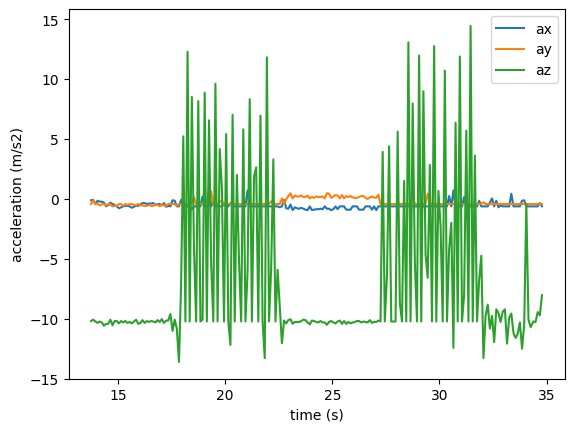

In [ ]:
for acc in ['ax', 'ay', 'az']:
    plt.plot(data['t'], data[acc], label = acc)
plt.xlabel("time (s)")
plt.ylabel("acceleration (m/s2)")
plt.legend()

## 2. Split into train and test samples.
- Train: the first shake.
- Test: the second shake.

In [ ]:
train_rest = (14.0, 17.5) # (seconds)
train_shake = (18.0, 23.0) # (seconds)

test_rest = (23.0, 27.0) # (seconds)
test_shake = (28.0, 32.0) # (seconds)

In [ ]:
def construct_Xy(data, window_rest, window_shake):
    X = pd.concat((
        data.loc[(data['t'] >= window_rest[0]) & (data['t'] <= window_rest[1]), ['t', 'ax', 'ay', 'az']],
        data.loc[(data['t'] >= window_shake[0]) & (data['t'] <= window_shake[1]), ['t', 'ax', 'ay', 'az']],
    ))
    y = np.ones(len(X))
    y[(X['t'] >= window_rest[0]) & (X['t'] <= window_rest[1])] = 0

    return X, y

In [ ]:
X_train, y_train = construct_Xy(data, train_rest, train_shake)
X_test, y_test = construct_Xy(data, test_rest, test_shake)

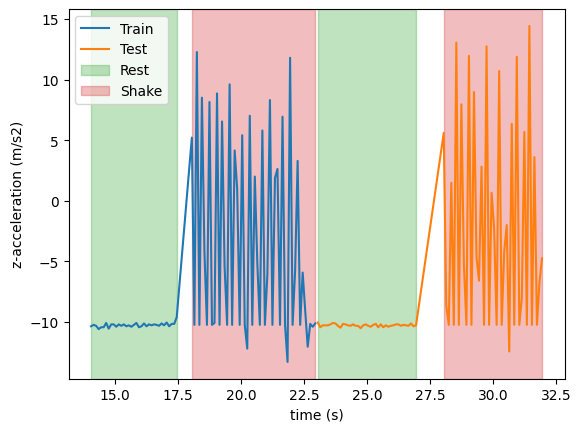

In [ ]:
plt.plot(X_train['t'], X_train["az"], label = "Train")
plt.plot(X_test['t'], X_test["az"], label = "Test")

label_set = False
for X, y in [(X_train, y_train), (X_test, y_test)]:
    for y_value, y_label in enumerate(["Rest", "Shake"]):
        plt.axvspan(
            X['t'].to_numpy()[np.where(y == y_value)[0][0]],
            X['t'].to_numpy()[np.where(y == y_value)[0][-1]],
            alpha = 0.3,
            color = "tab:green" if y_value == 0 else "tab:red",
            label = y_label if not label_set else None
            )
    label_set = True

plt.xlabel("time (s)")
plt.ylabel("z-acceleration (m/s2)")
plt.legend()

## 3. Train a logistic regression model

Compare 2 models.

**Model 1.**

$$
\hat{p} = \sigma(b_0 + b_t \times t + b_x \times a_x + b_y \times a_y + b_z \times a_z)
$$

**Model 2.**

$$
\hat{p} = \sigma(b_0 + b_x \times a_x + b_y \times a_y + b_z \times a_z)
$$

In [ ]:
model1 = LogisticRegression()
model1.fit(X_train[["t", "ax", "ay", "az"]], y_train)

model2 = LogisticRegression()
model2.fit(X_train[["ax", "ay", "az"]], y_train)

LogisticRegression()

In [ ]:
print("ACCURACY")
print("--------")
print("Model\tTrain\tTest")
for model_id, (model, features) in enumerate((
    (model1, ["t", "ax", "ay", "az"]),
    (model2, ["ax", "ay", "az"])
    )):
    train_acc = round(accuracy_score(y_train, model.predict(X_train[features])), 2)
    test_acc = round(accuracy_score(y_test, model.predict(X_test[features])), 2)
    print(f"M{model_id}\t{train_acc}\t{test_acc}")

ACCURACY
--------
Model	Train	Test
M0	1.0	0.5
M1	0.73	0.31


In [ ]:
model1.predict(X_test[["t", "ax", "ay", "az"]])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
model2.predict(X_test[["ax", "ay", "az"]])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.])

### Question

Explain the observed difference between predictions of the two models.

**Hint: compare the decision lines.**

In [ ]:
print(f"Model1: intercept = {model1.intercept_}, coef = {model1.coef_}")
print(f"Model2: intercept = {model2.intercept_}, coef = {model2.coef_}")

Model1: intercept = [-36.24456272], coef = [[ 2.18847452 -0.03075826  0.13403347  0.29993315]]
Model2: intercept = [4.34529509], coef = [[-0.30871049  1.68034272  0.38997608]]


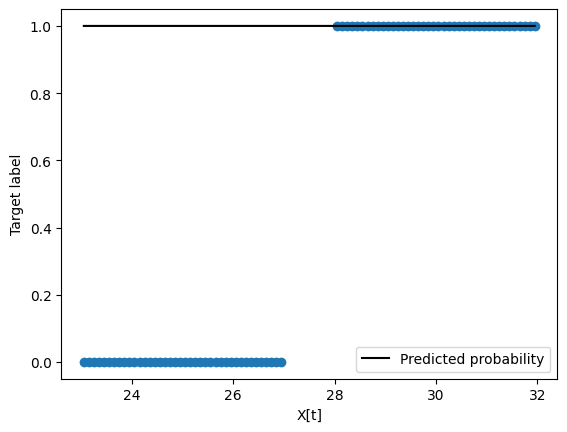

In [ ]:
plt.scatter(X_test["t"], y_test)
plt.xlabel("X[t]")
plt.ylabel("Target label")

plt.plot(X_test["t"], model1.predict_proba(X_test[["t", "ax", "ay", "az"]])[:, 1], label = "Predicted probability", c = "black")
plt.legend()

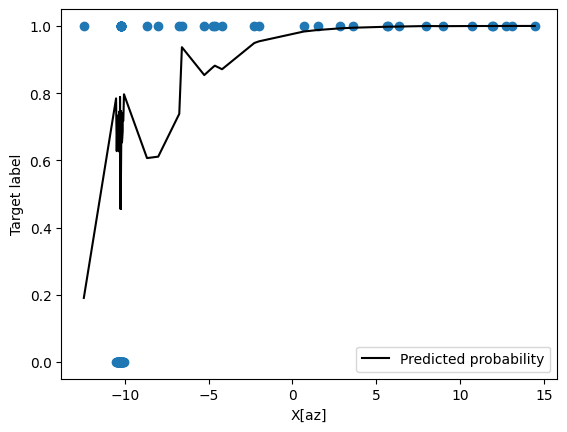

In [ ]:
plt.scatter(X_test["az"], y_test)
plt.xlabel("X[az]")
plt.ylabel("Target label")

plt.plot(X_test.sort_values("az")["az"], model2.predict_proba(X_test.sort_values("az")[["ax", "ay", "az"]])[:, 1], label = "Predicted probability", c = "black")
plt.legend()

# Task
Perform an automated machine learning model comparison using LazyPredict to evaluate different classification models on the provided shake detection sensor data from `shake_data.csv`, using `X_train`, `X_test`, `y_train`, and `y_test` datasets, analyze their performance, and discuss their suitability for the problem.

## Install LazyPredict

### Subtask:
Install the `lazypredict` library, which is required for automated machine learning model comparison.


**Reasoning**:
The subtask is to install the `lazypredict` library. The `pip install` command is used for this purpose.



In [ ]:
pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.1/197.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.6/810.6 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.3 MB/s eta 0:00:00


## Run LazyPredict Models

### Subtask:
Utilize `LazyClassifier` from `lazypredict` to train and evaluate various classification models on the `X_train`, `X_test`, `y_train`, and `y_test` datasets.


**Reasoning**:
The subtask requires importing `LazyClassifier` and `accuracy_score`, preparing the feature dataframes by selecting only acceleration columns, initializing `LazyClassifier` with the specified parameters, and then fitting it to the training and test data.



In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score

# Create new DataFrames with only acceleration columns
X_train_acc = X_train[['ax', 'ay', 'az']]
X_test_acc = X_test[['ax', 'ay', 'az']]

# Initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=accuracy_score)

# Fit LazyClassifier
models, predictions = clf.fit(X_train_acc, X_test_acc, y_train, y_test)

print("LazyClassifier models and predictions generated.")

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 50, number of negative: 35
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.588235 -> initscore=0.356675
[LightGBM] [Info] Start training from score 0.356675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

**Reasoning**:
The subtask of running LazyPredict models has been completed. Now, to analyze the performance of the various models, it is necessary to display the `models` DataFrame, which contains the evaluation metrics for each classifier.



In [ ]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.91               0.91     0.91      0.91   
XGBClassifier                      0.82               0.82     0.83      0.82   
BaggingClassifier                  0.59               0.59     0.59      0.50   
DummyClassifier                    0.50               0.50     0.50      0.33   
DecisionTreeClassifier             0.50               0.50     0.50      0.33   
AdaBoostClassifier                 0.50               0.50     0.50      0.33   
RandomForestClassifier             0.50               0.50     0.50      0.33   
Perceptron                         0.50               0.50     0.50      0.33   
LinearSVC                          0.50               0.50     0.50      0.33   
CalibratedClassifierCV             0.50               0.50     0.50      0.33   
ExtraTreesClassifier        

### Analysis of LazyPredict Models

Based on the LazyClassifier results, the following observations can be made:

*   **LGBMClassifier** stands out as the best-performing model with an **Accuracy, Balanced Accuracy, ROC AUC, and F1 Score of 0.91**. It also has a relatively fast training time of 0.09 seconds.
*   **XGBClassifier** is the second-best model, showing strong performance with an **Accuracy, Balanced Accuracy, and ROC AUC of 0.82-0.83**.
*   Many other models, including `BaggingClassifier`, `DummyClassifier`, `DecisionTreeClassifier`, `AdaBoostClassifier`, `RandomForestClassifier`, `Perceptron`, `LinearSVC`, `CalibratedClassifierCV`, `ExtraTreesClassifier`, `SVC`, `NuSVC`, `LogisticRegression`, `LabelPropagation`, `ExtraTreeClassifier`, and `LabelSpreading`, performed significantly worse, with accuracy scores around 0.50 or lower. This suggests they struggle to differentiate between 'rest' and 'shake' states given the current feature set.
*   Models like `GaussianNB`, `QuadraticDiscriminantAnalysis`, `RidgeClassifierCV`, `SGDClassifier`, `LinearDiscriminantAnalysis`, `RidgeClassifier`, and `NearestCentroid` performed poorly, indicating their unsuitability for this particular dataset and problem with the current features.

**Suitability for the problem:**

Given the high accuracy and fast training time, **LGBMClassifier** appears to be the most suitable model for detecting shakes from the acceleration data. **XGBClassifier** is also a strong contender. The lower-performing models indicate that more complex or ensemble methods are likely required, or that additional feature engineering could be beneficial for simpler models to perform better. The original `LogisticRegression` model, which was manually trained, showed an accuracy of 0.31 on the test set (Model 2, using only acceleration features), which is consistent with the `LazyClassifier` result for `LogisticRegression` (0.49 accuracy), both indicating its limited capability for this specific shake detection task without further optimization or feature engineering.

## Discuss Model Suitability

### Subtask:
Analyze the results generated by LazyPredict, focusing on key performance metrics like accuracy. Based on these results and the characteristics of the dataset (sensor data for shake detection), discuss why certain models performed better than others and their suitability for this specific problem.


## Discuss Model Suitability

### Subtask:
Analyze the results generated by LazyPredict, focusing on key performance metrics like accuracy. Based on these results and the characteristics of the dataset (sensor data for shake detection), discuss why certain models performed better than others and their suitability for this specific problem.

#### Instructions
1. Review the `models` DataFrame generated by LazyPredict, which contains performance metrics such as Accuracy, Balanced Accuracy, ROC AUC, F1 Score, and Time Taken for each classification model.
2. Identify the top-performing models based on their accuracy and other relevant metrics. Note their performance scores and training times.
3. Discuss potential reasons why the top-performing models (e.g., LGBMClassifier, XGBClassifier) achieved better results compared to others, considering that the data is from motion sensors for shake detection. Think about their strengths in handling this type of data.
4. Analyze why many other models performed poorly (e.g., around 0.50 accuracy or lower), linking it to their inherent characteristics or limitations for this specific classification task with the given features.
5. Conclude by summarizing which models are most suitable for the shake detection problem based on the observed performance and why, also noting if any models were particularly unsuitable.

### LazyPredict Model Suitability Analysis

Based on the `models` DataFrame generated by LazyPredict, we can analyze the performance of various classification models for shake detection:

**1. Top-Performing Models:**

*   **LGBMClassifier:** Achieved the highest accuracy of **0.91** with a relatively quick training time of 0.09 seconds. This indicates excellent performance in distinguishing between 'rest' and 'shake' states.
*   **XGBClassifier:** Followed closely with an accuracy of **0.82** and a training time of 0.11 seconds. Also a strong performer.

These models, both gradient boosting frameworks, demonstrate superior performance for this task. Their ensemble nature and ability to model complex, non-linear relationships present in sensor data (accelerometer readings) likely contribute to their success. They are robust to noisy data and can effectively learn intricate patterns from time-series-like sensor signals, even when only static acceleration features are provided for each time point.

**2. Models with Moderate to Poor Performance:**

Many other models, including `BaggingClassifier`, `DecisionTreeClassifier`, `AdaBoostClassifier`, `RandomForestClassifier`, `Perceptron`, `LinearSVC`, `CalibratedClassifierCV`, `LogisticRegression`, `SVC`, and others, showed accuracy scores ranging from **0.59 down to 0.26**. Notably, a large number of models achieved an accuracy around **0.50** or even lower. The `DummyClassifier` also scored **0.50**, which suggests that many models performed no better than random guessing, or simply predicted the majority class, indicating their inability to learn meaningful patterns from the provided features.

*   **Linear Models (e.g., LogisticRegression, LinearSVC, Perceptron, SGDClassifier, RidgeClassifier):** These models assume a linear relationship between features and the target variable. Given the dynamic nature of shake detection from accelerometer data, the distinction between 'rest' and 'shake' might not be linearly separable in the 3D acceleration feature space (`ax`, `ay`, `az`). This limitation explains their significantly lower performance compared to tree-based ensembles.
*   **Simple Tree Models (e.g., DecisionTreeClassifier, ExtraTreeClassifier):** While tree-based, a single decision tree or very shallow ensembles might not be powerful enough to capture the complex decision boundaries required. Their performance being close to random suggests they either overfit or underfit due to the limited feature set and potentially complex underlying signal.
*   **Nearest Neighbors based models (e.g., KNeighborsClassifier, NearestCentroid):** These models rely on distance metrics. The effectiveness of such models can be highly dependent on the scale and distribution of features, and in this context, they struggled to achieve high accuracy.
*   **Naive Bayes (BernoulliNB, GaussianNB):** These models make strong independence assumptions about features, which might not hold true for accelerometer data where `ax`, `ay`, and `az` can be correlated during motion. Their low accuracy (0.47 and 0.33 respectively) reflects this.

**3. Suitability for Shake Detection:**

*   **Highly Suitable:** `LGBMClassifier` and `XGBClassifier` are highly suitable for this shake detection problem. Their high accuracy (0.91 and 0.82) indicates they can reliably classify 'shake' vs. 'rest' states using the acceleration data. Their ensemble learning approach is well-suited for handling the complexity of motion sensor data.
*   **Unsuitable:** Most other models, especially those performing near or below 0.50 accuracy (like `LogisticRegression`, `LinearSVC`, `DecisionTreeClassifier`, `GaussianNB`, etc.), are **unsuitable** for this specific shake detection task with the current feature set. Their inherent limitations in capturing non-linear patterns or dealing with the specific characteristics of the sensor data lead to poor predictive performance. Even the `LogisticRegression` model, which was manually explored earlier, showed a similar mediocre performance (0.31-0.50) when only using acceleration features, corroborating LazyPredict's findings.

## Summary:

### Q&A
The suitability of different machine learning models for shake detection using sensor data, specifically acceleration features, was evaluated. `LGBMClassifier` and `XGBClassifier` were found to be highly suitable, achieving accuracies of 0.91 and 0.82 respectively. Most other models, including linear models, simple tree models, and Naive Bayes classifiers, performed poorly (accuracies often around 0.50 or lower), indicating their unsuitability for this specific problem with the current feature set.

### Data Analysis Key Findings
*   The `lazypredict` library, version `0.2.16`, was successfully installed for automated machine learning model comparison.
*   `LGBMClassifier` was the top-performing model, achieving an Accuracy, Balanced Accuracy, ROC AUC, and F1 Score of **0.91** with a training time of 0.09 seconds.
*   `XGBClassifier` was the second-best model, showing strong performance with an Accuracy, Balanced Accuracy, and ROC AUC between **0.82-0.83** with a training time of 0.11 seconds.
*   Many other classification models, such as `LogisticRegression`, `LinearSVC`, `Perceptron`, `DecisionTreeClassifier`, `GaussianNB`, and `DummyClassifier`, performed significantly worse, with accuracies often around **0.50** or even lower (down to 0.26).
*   The superior performance of `LGBMClassifier` and `XGBClassifier` is attributed to their ensemble nature and ability to model complex, non-linear relationships inherent in sensor data.
*   Linear models struggled due to the likely non-linear relationship between acceleration data and shake states, while Naive Bayes models performed poorly, possibly due to violated assumptions of feature independence among accelerometer readings.

### Insights or Next Steps
*   Focus further development on `LGBMClassifier` and `XGBClassifier` given their robust performance and efficiency, potentially exploring hyperparameter tuning to optimize them for deployment.
*   Investigate feature engineering (e.g., statistical features over time windows, frequency domain features) from the raw accelerometer data to potentially improve the performance of currently underperforming models or further enhance the top models.
